SOLAR PV PREPROCESSING - MULTI-LOCATION TRAINING, SINGLE LOCATION PREDICTION

1. Loading raw data files...


C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pv_data['LocalTime'] = pd.to_datetime(pv_data['LocalTime'])
C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data['LocalTime'] = pd.to_datetime(weather_data['LocalTime'])



Available locations:
1. Latitude: 41.55, Longitude: -74.35
2. Latitude: 42.05, Longitude: -74.25
3. Latitude: 42.55, Longitude: -73.95
4. Latitude: 42.85, Longitude: -74.05
5. Latitude: 42.95, Longitude: -74.05
6. Latitude: 40.85, Longitude: -73.85
7. Latitude: 41.05, Longitude: -73.65
8. Latitude: 41.05, Longitude: -73.75
9. Latitude: 41.05, Longitude: -73.85
10. Latitude: 41.15, Longitude: -73.65
11. Latitude: 41.15, Longitude: -73.75
12. Latitude: 41.15, Longitude: -73.85
13. Latitude: 41.15, Longitude: -73.95
14. Latitude: 41.15, Longitude: -74.05
15. Latitude: 41.25, Longitude: -73.55
16. Latitude: 41.25, Longitude: -73.65
17. Latitude: 41.25, Longitude: -73.75
18. Latitude: 41.25, Longitude: -73.85
19. Latitude: 41.25, Longitude: -74.05
20. Latitude: 41.25, Longitude: -74.15

Selected TARGET location: Latitude 41.55, Longitude -74.35

3. Resampling all PV data to 30-minute intervals...
Resampling each location...


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = group.resample('30T').agg({
  5%|▌         | 1/20 [00:00<00:06,  3.15it/s]C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = group.resample('30T').agg({
C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = group.resample('30T').agg({
C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = group.resample('30T').agg({
C:\Users\vexbr\AppData\Local\Temp\ipykernel_16076\2675728440.py:52: FutureWa

Resampled PV data: (350400, 8) rows

4. Merging PV and weather data by location and time...
Processing 20 locations...


 20%|██        | 4/20 [00:00<00:01,  8.49it/s]

Saved target location data with 17520 rows


100%|██████████| 20/20 [00:01<00:00, 14.70it/s]


Combined data shape: (350400, 33)

5. Creating features for ML models...
Creating lag features...


100%|██████████| 20/20 [00:01<00:00, 19.50it/s]



6. Creating data splits with evenly distributed test days...
Target location data: 17520 rows
Other locations data: 332880 rows
Total days in target location: 365
Target location train: 14640 rows from 305 days
Target location val: 0 rows from 0 days
Target location test: 2880 rows from 60 days

7. Creating final datasets...
Final training data: 347520 rows
Final validation data: 0 rows
Final test data: 2880 rows

PREPROCESSING COMPLETE - TRAIN ALL, PREDICT ONE
All data processed for 20 locations
Target location for prediction: loc_41p55_-74p35
Output files saved to processed_data/train_all_predict_one/ directory


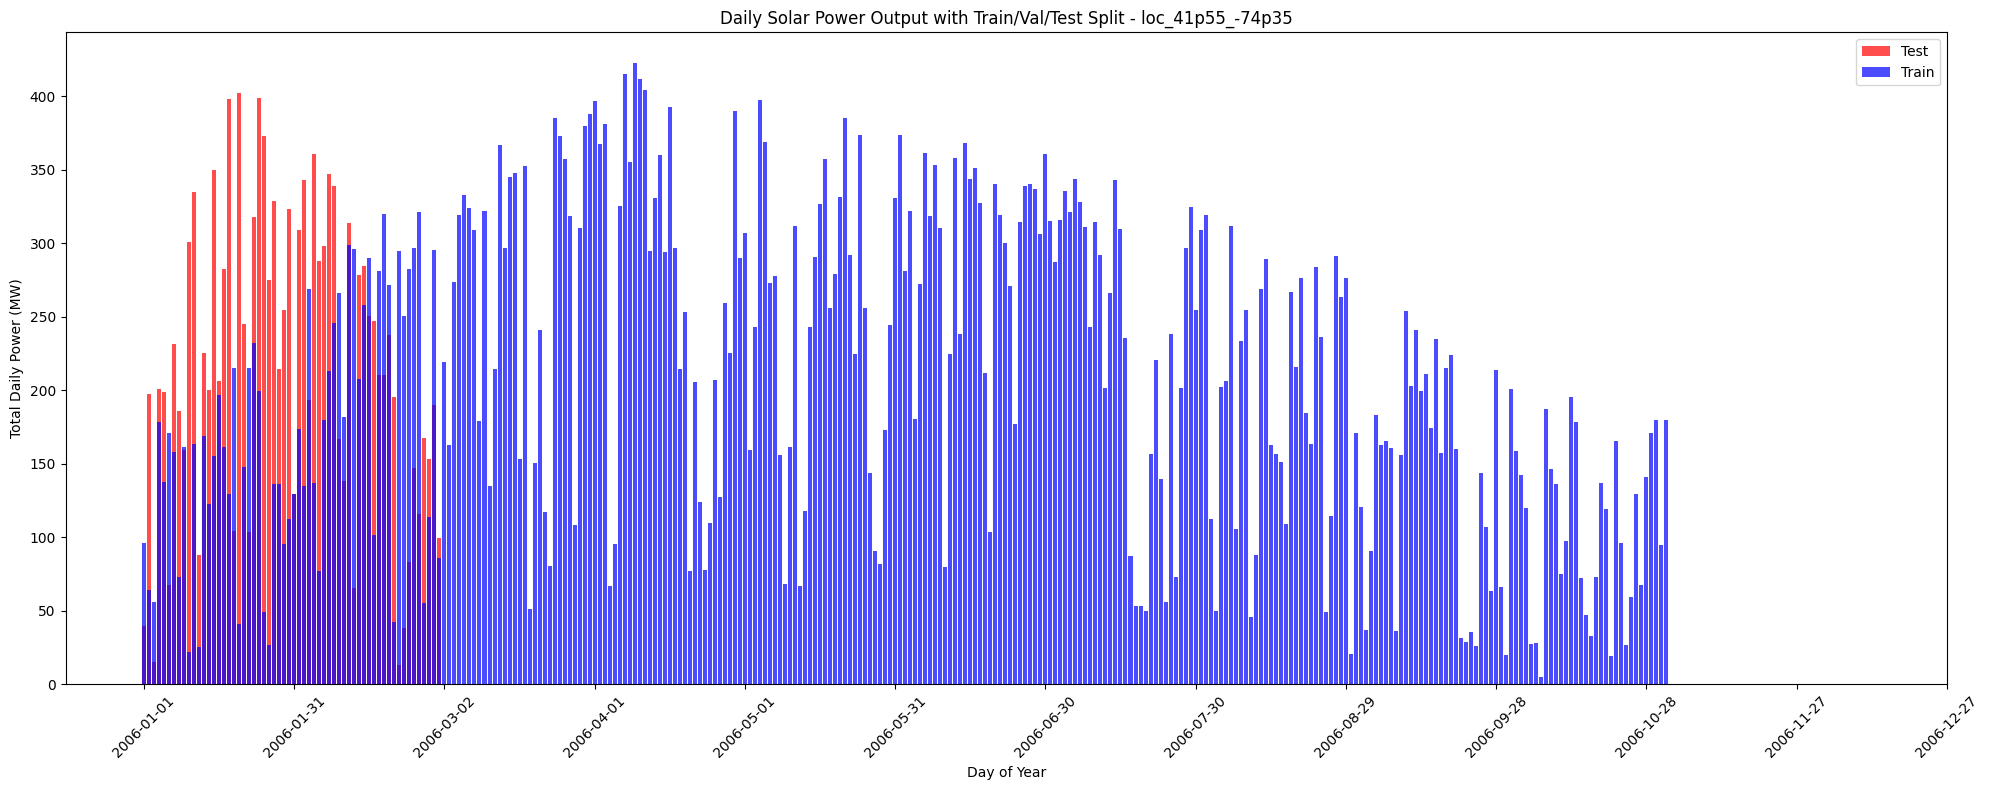

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

print("="*80)
print("SOLAR PV PREPROCESSING - MULTI-LOCATION TRAINING, SINGLE LOCATION PREDICTION")
print("="*80)

# 1. Load data
print("\n1. Loading raw data files...")
pv_data = pd.read_csv('combined_pv_data_20.csv')
weather_data = pd.read_csv('converted_weather_data.csv')

# Convert timestamps
pv_data['LocalTime'] = pd.to_datetime(pv_data['LocalTime'])
weather_data['LocalTime'] = pd.to_datetime(weather_data['LocalTime'])

# 2. Select one location for prediction (target location)
# Get available locations
locations = pv_data[['Latitude', 'Longitude']].drop_duplicates().values

# Print available locations for user to choose
print("\nAvailable locations:")
for i, (lat, lon) in enumerate(locations):
    print(f"{i+1}. Latitude: {lat}, Longitude: {lon}")

# For this example, let's use the first location as target
target_idx = 0  # Change this to select different target location
target_lat, target_lon = locations[target_idx]
print(f"\nSelected TARGET location: Latitude {target_lat}, Longitude {target_lon}")
target_location_id = f"loc_{str(target_lat).replace('.', 'p')}_{str(target_lon).replace('.', 'p')}"

# 3. Resampling PV data to 30-minute intervals for all locations
print("\n3. Resampling all PV data to 30-minute intervals...")

# First set the index to LocalTime for resampling
pv_data.set_index('LocalTime', inplace=True)

# Group by location and resample
print("Resampling each location...")
location_groups = pv_data.groupby(['Latitude', 'Longitude'])
resampled_pv_dfs = []

for (lat, lon), group in tqdm(location_groups):
    # Create location ID
    location_id = f"loc_{str(lat).replace('.', 'p')}_{str(lon).replace('.', 'p')}"
    
    # Resample to 30 minutes
    resampled = group.resample('30T').agg({
        'PV_Type': 'first',
        'Capacity_MW': 'first',
        'Power(MW)': 'mean',
        'Power_Normalized': 'mean'
    })
    # Add location back
    resampled['Latitude'] = lat
    resampled['Longitude'] = lon
    resampled['location_id'] = location_id
    resampled_pv_dfs.append(resampled)

# Combine resampled data
pv_data_30min = pd.concat(resampled_pv_dfs)
pv_data_30min.reset_index(inplace=True)
print(f"Resampled PV data: {pv_data_30min.shape} rows")

# 4. Merge PV and Weather data
print("\n4. Merging PV and weather data by location and time...")

# Prepare weather data for merge
weather_data.set_index('LocalTime', inplace=True)
weather_locs = weather_data.reset_index()[['Latitude', 'Longitude']].drop_duplicates().values

# Process each location
merged_dfs = []
print(f"Processing {len(locations)} locations...")

for lat, lon in tqdm(locations):
    # Get PV data for this location
    loc_id = f"loc_{str(lat).replace('.', 'p')}_{str(lon).replace('.', 'p')}"
    pv_loc = pv_data_30min[pv_data_30min['location_id'] == loc_id].copy()
    
    # Find closest weather location
    distances = np.sqrt((weather_locs[:, 0] - lat)**2 + (weather_locs[:, 1] - lon)**2)
    closest_idx = np.argmin(distances)
    weather_lat, weather_lon = weather_locs[closest_idx]
    
    # Get weather data for this location
    weather_loc = weather_data[(weather_data['Latitude'] == weather_lat) & 
                              (weather_data['Longitude'] == weather_lon)].copy()
    weather_loc = weather_loc.reset_index()
    
    # Merge by timestamp
    merged = pd.merge(pv_loc, weather_loc, on='LocalTime', 
                      suffixes=('_pv', '_weather'))
    
    merged_dfs.append(merged)
    
    # Save individual location data if needed
    if lat == target_lat and lon == target_lon:
        os.makedirs('processed_data/target_location', exist_ok=True)
        merged.to_csv(f'processed_data/target_location/{loc_id}_full.csv', index=False)
        print(f"Saved target location data with {len(merged)} rows")

# Combine all merged data
combined_data = pd.concat(merged_dfs, ignore_index=True)
print(f"Combined data shape: {combined_data.shape}")

# 5. Feature Engineering
print("\n5. Creating features for ML models...")

# Add basic time features
combined_data['hour'] = combined_data['LocalTime'].dt.hour
combined_data['day'] = combined_data['LocalTime'].dt.day
combined_data['month'] = combined_data['LocalTime'].dt.month
combined_data['dayofyear'] = combined_data['LocalTime'].dt.dayofyear
combined_data['dayofweek'] = combined_data['LocalTime'].dt.dayofweek
combined_data['is_daylight'] = combined_data['hour'].between(6, 18)
combined_data['date'] = combined_data['LocalTime'].dt.date

# Add cyclical time features
combined_data['hour_sin'] = np.sin(2 * np.pi * combined_data['hour'] / 24)
combined_data['hour_cos'] = np.cos(2 * np.pi * combined_data['hour'] / 24)
combined_data['month_sin'] = np.sin(2 * np.pi * combined_data['month'] / 12)
combined_data['month_cos'] = np.cos(2 * np.pi * combined_data['month'] / 12)
combined_data['dayofyear_sin'] = np.sin(2 * np.pi * combined_data['dayofyear'] / 365)
combined_data['dayofyear_cos'] = np.cos(2 * np.pi * combined_data['dayofyear'] / 365)

# Create lag features for LSTM (location-specific)
print("Creating lag features...")
combined_data.sort_values(['location_id', 'LocalTime'], inplace=True)

# Calculate lag features by location
for loc_id in tqdm(combined_data['location_id'].unique()):
    loc_mask = combined_data['location_id'] == loc_id
    
    # Power output lags
    for lag in range(1, 4):  # 1 to 3 time steps (30min to 1.5 hours)
        combined_data.loc[loc_mask, f'power_lag_{lag}'] = (
            combined_data.loc[loc_mask, 'Power(MW)'].shift(lag)
        )
    
    # Weather lags for key features
    for feature in ['Temperature', 'GHI', 'Cloud_Type']:
        if feature in combined_data.columns:
            for lag in range(1, 3):  # 1 to 2 time steps
                combined_data.loc[loc_mask, f'{feature}_lag_{lag}'] = (
                    combined_data.loc[loc_mask, feature].shift(lag)
                )

# Fill NA from lag creation
combined_data.fillna(0, inplace=True)

# Improved test split strategy - this replaces section 6 in the previous code

print("\n6. Creating data splits with evenly distributed test days...")

# Filter the target location data
target_data = combined_data[combined_data['location_id'] == target_location_id].copy()
other_locations_data = combined_data[combined_data['location_id'] != target_location_id].copy()

print(f"Target location data: {len(target_data)} rows")
print(f"Other locations data: {len(other_locations_data)} rows")

# Get all unique days in target location
target_days = sorted(target_data['date'].unique())
n_days = len(target_days)
print(f"Total days in target location: {n_days}")

# Select test days distributed more evenly throughout the year
# Take approximately every 6th day as a test day starting from the 5th day
test_indices = list(range(5, n_days, 6))  # This gives ~60 test days through the year
test_days = [target_days[i] for i in test_indices]

# Take every 12th day as validation, offset from test days
val_indices = list(range(11, n_days, 12))  # This gives ~30 validation days
val_days = [target_days[i] for i in val_indices]

# Make sure there's no overlap
val_days = [day for day in val_days if day not in test_days]

# Create masks for target location
test_mask = target_data['date'].isin(test_days)
val_mask = target_data['date'].isin(val_days)
train_mask = ~(test_mask | val_mask)

# Split the target data
target_train = target_data[train_mask].copy()
target_val = target_data[val_mask].copy()
target_test = target_data[test_mask].copy()

print(f"Target location train: {len(target_train)} rows from {len(target_train['date'].unique())} days")
print(f"Target location val: {len(target_val)} rows from {len(target_val['date'].unique())} days")
print(f"Target location test: {len(target_test)} rows from {len(target_test['date'].unique())} days")

# 7. Create final training, validation and test sets
print("\n7. Creating final datasets...")

# Training: All data from other locations + training portion of target location
train_data = pd.concat([other_locations_data, target_train], ignore_index=True)

# Val/Test: Just from target location
val_data = target_val.copy()
test_data = target_test.copy()

print(f"Final training data: {len(train_data)} rows")
print(f"Final validation data: {len(val_data)} rows")
print(f"Final test data: {len(test_data)} rows")

# 8. Save all datasets
os.makedirs('processed_data/train_all_predict_one', exist_ok=True)

# Save the processed datasets
train_data.to_csv(f'processed_data/train_all_predict_one/train_data.csv', index=False)
val_data.to_csv(f'processed_data/train_all_predict_one/val_data.csv', index=False)
test_data.to_csv(f'processed_data/train_all_predict_one/test_data.csv', index=False)

# 9. Generate visualization of the train/test/validation split for target location
plt.figure(figsize=(20, 8))

# Group by date and calculate daily total for target location
daily_power = target_data.groupby('date')['Power(MW)'].sum().reset_index()

# Add dataset labels
daily_power['dataset'] = 'Unknown'
for idx, day in enumerate(daily_power['date']):
    if day in test_days:
        daily_power.loc[idx, 'dataset'] = 'Test'
    elif day in val_days:
        daily_power.loc[idx, 'dataset'] = 'Validation'
    else:
        daily_power.loc[idx, 'dataset'] = 'Train'

# Sort by date
daily_power = daily_power.sort_values('date')

# Plot
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red', 'Unknown': 'gray'}

for dataset, group in daily_power.groupby('dataset'):
    plt.bar(range(len(group)), group['Power(MW)'], label=dataset, 
            alpha=0.7, color=colors[dataset])

plt.title(f'Daily Solar Power Output with Train/Val/Test Split - {target_location_id}')
plt.xlabel('Day of Year')
plt.ylabel('Total Daily Power (MW)')
plt.legend()
plt.xticks(range(0, len(daily_power), 30), 
          [date.strftime('%Y-%m-%d') for date in daily_power['date'].iloc[range(0, len(daily_power), 30)]], 
          rotation=45)
plt.tight_layout()
plt.savefig(f'processed_data/train_all_predict_one/target_split_visualization.png')

print("\n" + "="*80)
print("PREPROCESSING COMPLETE - TRAIN ALL, PREDICT ONE")
print("="*80)
print(f"All data processed for {len(combined_data['location_id'].unique())} locations")
print(f"Target location for prediction: {target_location_id}")
print(f"Output files saved to processed_data/train_all_predict_one/ directory")